**Nama Kelompok:**
1. Layyinatul Qolbiyah (23031554025)
2. Ummul Khoiro' Syari (23031554074)
3. Novia Djoend Lestari (23031554220)

**Install dan Import Library**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 27.9 MB/s eta 0:00:00


In [ ]:
pip install pyzipper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 1.2 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import graycomatrix, graycoprops, hog
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE

In [ ]:
zip_file_path = '/content/archive (1).zip'
extract_path = '/content/brain_tumor_extract'

if zipfile.is_zipfile(zip_file_path):
    print("File ZIP valid, melanjutkan ekstraksi...")
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("File bukan file ZIP yang valid atau rusak!")

def check_coco_annotation(folder):
    for fname in os.listdir(folder):
        if fname.endswith('.json') and ('anno' in fname or 'annotation' in fname):
            return os.path.join(folder, fname)
    return None

def count_images(folder):
    return len([f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

folders = ['train', 'valid', 'test']
annotations_summary = {}

for f in folders:
    folder_path = os.path.join(extract_path, f)
    if os.path.exists(folder_path):
        print(f"\nCek anotasi di folder: {folder_path}")
        ann_file = check_coco_annotation(folder_path)
        if ann_file:
            print(f"File anotasi COCO ditemukan: {ann_file}")
            with open(ann_file, 'r') as fjson:
                data = json.load(fjson)

            tumor_count = sum(1 for anno in data['annotations'] if anno['category_id'] == 2)
            no_tumor_count = sum(1 for anno in data['annotations'] if anno['category_id'] == 1)

            annotations_summary[f] = {
                'tumor': tumor_count,
                'no_tumor': no_tumor_count
            }
        else:
            print("File anotasi COCO tidak ditemukan.")
            annotations_summary[f] = {
                'tumor': 0,
                'no_tumor': 0
            }
    else:
        print(f"Folder {folder_path} tidak ada.")
        annotations_summary[f] = {
            'tumor': 0,
            'no_tumor': 0
        }

base_train_folder = os.path.join(extract_path, 'train')
base_valid_folder = os.path.join(extract_path, 'valid')
base_test_folder = os.path.join(extract_path, 'test')

print(f"\nTotal gambar train: {count_images(base_train_folder)}")
print(f"Total gambar valid: {count_images(base_valid_folder)}")
print(f"Total gambar test: {count_images(base_test_folder)}")

print("\nJumlah anotasi per folder:")
for folder_name in folders:
    tumor = annotations_summary[folder_name]['tumor']
    no_tumor = annotations_summary[folder_name]['no_tumor']
    print(f"{folder_name}: Tumor = {tumor}, No Tumor = {no_tumor}")

folder_names = folders
tumor_counts = [annotations_summary[f]['tumor'] for f in folder_names]
no_tumor_counts = [annotations_summary[f]['no_tumor'] for f in folder_names]

x = np.arange(len(folder_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, tumor_counts, width, label='Tumor', color='orange')
bars2 = ax.bar(x + width/2, no_tumor_counts, width, label='No Tumor', color='blue')

ax.set_ylabel('Jumlah Anotasi')
ax.set_xlabel('Folder Dataset')
ax.set_title('Distribusi Anotasi Tumor vs. Non-Tumor per Folder')
ax.set_xticks(x)
ax.set_xticklabels(folder_names)
ax.legend()

for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Pra-pemrosesan**

In [ ]:
IMG_SIZE = 224

def load_coco_images_and_labels(image_folder, annotation_file):
    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)

    id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
    id_to_label = {anno['image_id']: anno['category_id'] for anno in coco_data['annotations']}

    X, y, fnames = [], [], []
    for img_id, fname in id_to_filename.items():
        label_id = id_to_label.get(img_id, None)
        if label_id is None:
            continue

        label_name = 1 if label_id == 2 else 0
        img_path = os.path.join(image_folder, fname)
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.medianBlur(img, 5)
        X.append(img)
        y.append(label_name)
        fnames.append(fname)

    return np.array(X), np.array(y), fnames

ann_train = check_coco_annotation(base_train_folder)
ann_test = check_coco_annotation(base_test_folder)
ann_valid = check_coco_annotation(base_valid_folder)

X_train, y_train, _ = load_coco_images_and_labels(base_train_folder, ann_train)
X_test, y_test, test_fnames = load_coco_images_and_labels(base_test_folder, ann_test)
X_valid, y_valid, _ = load_coco_images_and_labels(base_valid_folder, ann_valid)

**Ekstraksi Fitur**

In [ ]:
# Feature extraction functions
def extract_glcm_features(images):
    features = []
    for img in images:
        img = (img * 255).astype(np.uint8) if img.dtype != np.uint8 else img
        glcm = graycomatrix(img, distances=[1, 3, 5, 7],
                            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            levels=256, symmetric=True, normed=True)
        props = ['contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'dissimilarity']
        ftrs = [np.mean(graycoprops(glcm, p)) for p in props]
        features.append(ftrs)
    return np.array(features)

def extract_hog_features(images):
    hog_features = []
    for img in images:
        f, _ = hog(img, orientations=9, pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        hog_features.append(f)
    return np.array(hog_features)

In [ ]:
# Extract and combine features
X_train_feat = np.concatenate([extract_glcm_features(X_train), extract_hog_features(X_train)], axis=1)
X_valid_feat = np.concatenate([extract_glcm_features(X_valid), extract_hog_features(X_valid)], axis=1)
X_test_feat = np.concatenate([extract_glcm_features(X_test), extract_hog_features(X_test)], axis=1)

scaler = StandardScaler()
X_train_feat = scaler.fit_transform(X_train_feat)
X_valid_feat = scaler.transform(X_valid_feat)
X_test_feat = scaler.transform(X_test_feat)

X_full = np.concatenate([X_train_feat, X_valid_feat], axis=0)
y_full = np.concatenate([y_train, y_valid], axis=0)


**Penyeimbangan Data**

In [ ]:
sm = SMOTE(random_state=42)
X_balanced, y_balanced = sm.fit_resample(X_full, y_full)

**Reduksi Dimensi**

In [ ]:
# PCA
pca = PCA(n_components=0.98)
X_pca = pca.fit_transform(X_balanced)
X_test_pca = pca.transform(X_test_feat)

**Pelatihan Model**

In [ ]:

# SVM training
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_pca, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_split, y_train_split)
model = grid.best_estimator_

In [ ]:
# Thresholded prediction
probs = model.predict_proba(X_test_pca)[:, 1]
y_pred_thresh = (probs > 0.6).astype(int)


**Evaluasi Model**

File ZIP valid, melanjutkan ekstraksi...

Cek anotasi di folder: /content/brain_tumor_extract/train
File anotasi COCO ditemukan: /content/brain_tumor_extract/train/_annotations.coco.json

Cek anotasi di folder: /content/brain_tumor_extract/valid
File anotasi COCO ditemukan: /content/brain_tumor_extract/valid/_annotations.coco.json

Cek anotasi di folder: /content/brain_tumor_extract/test
File anotasi COCO ditemukan: /content/brain_tumor_extract/test/_annotations.coco.json

Total gambar train: 1502
Total gambar valid: 429
Total gambar test: 215

Jumlah anotasi per folder:
train: Tumor = 731, No Tumor = 771
valid: Tumor = 219, No Tumor = 210
test: Tumor = 97, No Tumor = 118


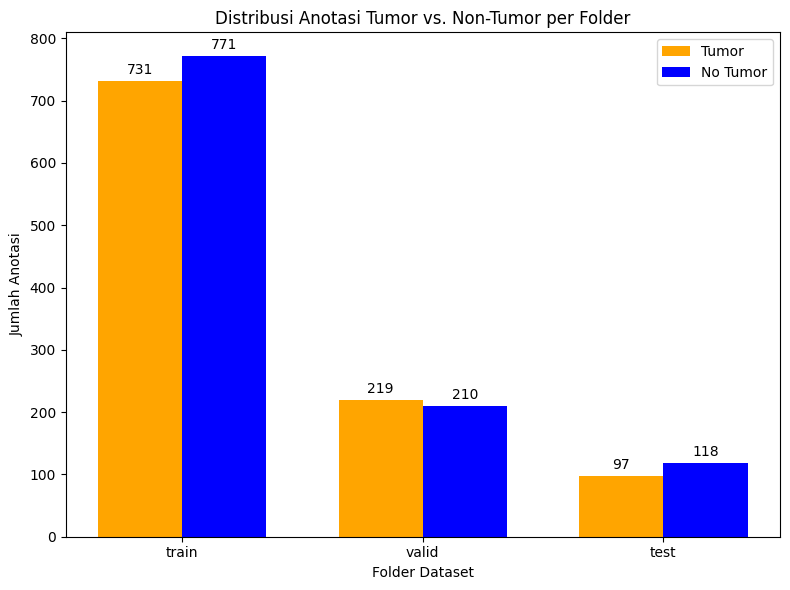

Classification Report (Test):
               precision    recall  f1-score   support

    No Tumor       0.99      0.98      0.99       118
       Tumor       0.98      0.99      0.98        97

    accuracy                           0.99       215
   macro avg       0.99      0.99      0.99       215
weighted avg       0.99      0.99      0.99       215



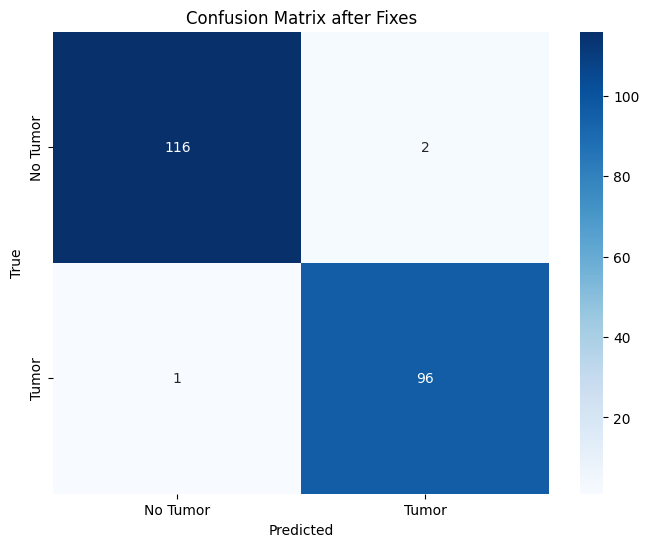

In [ ]:

print("Classification Report (Test):\n", classification_report(
    y_test, y_pred_thresh, target_names=['No Tumor', 'Tumor']))

cm = confusion_matrix(y_test, y_pred_thresh)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Tumor', 'Tumor'],
            yticklabels=['No Tumor', 'Tumor'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix after Fixes")
plt.show()




**Visualisasi Prediksi Model dengan Highlight Tumor**

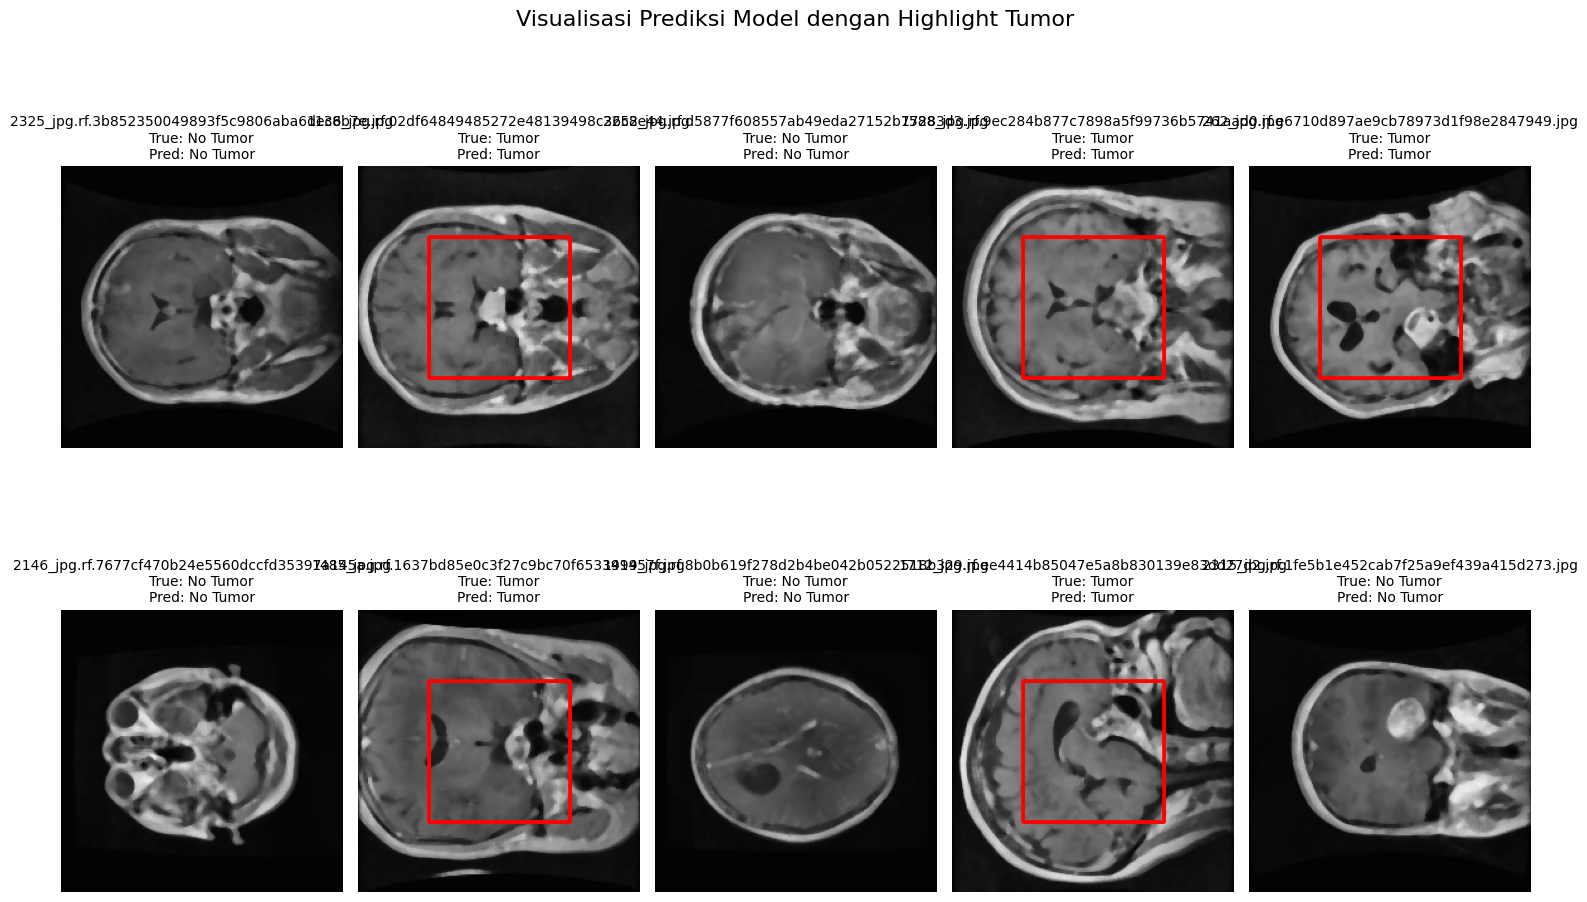

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

def visualize_predictions(X_imgs, y_true, y_pred, filenames=None, n_samples=10):
    plt.figure(figsize=(15, 10))
    indices = random.sample(range(len(X_imgs)), min(n_samples, len(X_imgs)))

    for i, idx in enumerate(indices):
        img = X_imgs[idx]
        if img.dtype != np.uint8:
            img = (img * 255).astype(np.uint8)

        # Pastikan gambar bentuk grayscale
        if len(img.shape) == 2:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            img_rgb = img.copy()

        true_label = 'Tumor' if y_true[idx] == 1 else 'No Tumor'
        pred_label = 'Tumor' if y_pred[idx] == 1 else 'No Tumor'

        # Tandai gambar dengan kotak merah jika prediksi atau ground truth Tumor
        if y_true[idx] == 1 or y_pred[idx] == 1:
            h, w = img.shape[:2]
            start_point = (w//4, h//4)
            end_point = (3*w//4, 3*h//4)
            img_rgb = cv2.rectangle(img_rgb, start_point, end_point, (255, 0, 0), 2)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        title = f"True: {true_label}\nPred: {pred_label}"
        if filenames:
            title = f"{filenames[idx]}\n" + title
        plt.title(title, fontsize=10)

    plt.tight_layout()
    plt.suptitle("Visualisasi Prediksi Model dengan Highlight Tumor", fontsize=16, y=1.02)
    plt.show()
visualize_predictions(X_test.squeeze(), y_test, y_pred_thresh, filenames=test_fnames)